In [18]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lasair

project_root = Path("/Users/david/Code/msc/project")
data_path = project_root / "data"
src_path = project_root / "src"
print(f"Looking for src at: {src_path}")
print(f"Does src directory exist: {src_path.exists()}")
if src_path.exists():
    print(f"Contents of src: {list(src_path.glob('*'))}")

sys.path.append(str(src_path))
print(f"Added to sys.path: {src_path}")
print(f"Current working directory: {Path.cwd()}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking for src at: /Users/david/Code/msc/project/src
Does src directory exist: True
Contents of src: [PosixPath('/Users/david/Code/msc/project/src/__pycache__'), PosixPath('/Users/david/Code/msc/project/src/utils.py'), PosixPath('/Users/david/Code/msc/project/src/.ipynb_checkpoints'), PosixPath('/Users/david/Code/msc/project/src/test.ipynb'), PosixPath('/Users/david/Code/msc/project/src/process.ipynb')]
Added to sys.path: /Users/david/Code/msc/project/src
Current working directory: /Users/david/Code/msc/project/src


In [19]:
ZTF_CSV_PATH = data_path / "ztf.csv"
df = pd.read_csv(ZTF_CSV_PATH)
print(f"Loaded {len(df)} objects from ztf.csv (read-only)")
df.head()

Loaded 7070 objects from ztf.csv (read-only)


,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
0,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,59.641962,0.053
1,ZTF17aabvong,SN2024xxq,02:05:07.68,+11:14:55.1,2606.75,g,16.8039,-19.57,23.222,8.464,14.758,SN Ia,0.034,-47.664064,0.446
2,ZTF17aacldgo,SN2022zxv,03:09:24.36,-04:53:39.2,1897.75,g,18.7979,-18.91,>1077,>3.85,>1073.15,SN Ia,0.072,-50.332472,0.183
3,ZTF17aadlxmv,SN2020adv,08:29:47.59,+33:54:22.8,879.69,g,17.9475,-19.34,25.146,10.951,14.195,SN Ia,0.062,34.174702,0.106
4,ZTF18aaaibml,SN2020buc,10:08:31.27,+09:14:23.0,909.80,r,18.2606,-17.70,69.73,27.302,42.428,SN II,0.0348,47.637802,0.092


In [ ]:
# Import utils
from utils import download_lasair_csv, download_tns_ascii, plot_object_data, update_tracker, process_sncosmo
from datetime import datetime

# User input prompts
def get_user_input():
    """Get ID (or 'all' for all rows) and --force flag from user input."""
    ztf_id = input("Enter ZTF ID (e.g., ZTF17aabtvsy) or 'all' for all rows: ").strip()
    force = input("Force run? (y/n, default: n): ").strip().lower() == 'y'
    return ztf_id, force

# Get user inputs
ztf_id, force_run = get_user_input()
process_all = ztf_id.lower() in ['all', 'a', '']

if process_all:
    print(f"\nProcessing ALL {len(df)} objects from ztf.csv")
    print(f"Force run: {force_run}")
    # Create a copy to ensure original df is never modified
    objects_to_process = df.copy()
else:
    print(f"\nProcessing ZTF ID: {ztf_id}")
    print(f"Force run: {force_run}")
    objects_to_process = df[df['ZTFID'] == ztf_id].copy()
    
    if objects_to_process.empty:
        print(f"Warning: No data found for ZTF ID {ztf_id}")
        print(f"Available IDs (first 10): {df['ZTFID'].head(10).tolist()}")
    else:
        print(f"\nFound {len(objects_to_process)} entry(ies) for {ztf_id}")
        print(objects_to_process[['ZTFID', 'IAUID', 'type', 'peakmag', 'peakt']].to_string())


Processing ZTF ID: ZTF17aabtvsy
Force run: False

Found 1 entry(ies) for ZTF17aabtvsy
          ZTFID      IAUID   type  peakmag    peakt
0  ZTF17aabtvsy  SN2022yei  SN Ia  18.0303  1870.99


In [ ]:
# Download data for objects
if not objects_to_process.empty:
    total = len(objects_to_process)
    download_results = []  # Store results for plotting
    
    for idx, (_, obj_row) in enumerate(objects_to_process.iterrows(), 1):
        ztf_id = obj_row['ZTFID']
        tns_id = obj_row['IAUID']
        # Remove "SN" prefix from TNS ID if present
        if tns_id.startswith('SN'):
            tns_id = tns_id[2:]
        
        lasair_csv_path = None
        lasair_status = None
        tns_ascii_path = None
        tns_status = None
        
        try:
            # Download Lasair CSV data
            try:
                lasair_csv_path = download_lasair_csv(ztf_id)
                lasair_status = "downloaded"
            except Exception as lasair_error:
                lasair_csv_path = None
                lasair_status = f"failed: {str(lasair_error)}"

            # Download TNS ASCII
            try:
                tns_ascii_path = download_tns_ascii(tns_id)
                tns_status = "downloaded"
            except Exception as tns_error:
                tns_ascii_path = None
                tns_status = f"failed: {str(tns_error)}"
            
            # Update tracker with both statuses
            update_tracker(
                ztf_id,
                lasair_status=lasair_status,
                lasair_path=Path(lasair_csv_path) if lasair_csv_path else None,
                tns_status=tns_status,
                tns_path=Path(tns_ascii_path) if tns_ascii_path else None
            )
            
            download_results.append({
                'ztf_id': ztf_id,
                'lasair_csv_path': lasair_csv_path,
                'tns_ascii_path': tns_ascii_path,
                'tns_status': tns_status,
                'lasair_status': lasair_status
            })
            
            print(f"[{idx}/{total}] {ztf_id}: lasair:{lasair_status} tns:{tns_status}")
        except Exception as e:
            print(f"[{idx}/{total}] {ztf_id}: Failed - {str(e)}")
            # Update tracker with failure status
            update_tracker(
                ztf_id,
                lasair_status=lasair_status or f"failed: {str(e)}",
                lasair_path=None,
                tns_status=tns_status or f"failed: {str(e)}",
                tns_path=None
            )
            download_results.append({
                'ztf_id': ztf_id,
                'lasair_csv_path': None,
                'tns_ascii_path': None,
                'tns_status': f"failed: {str(e)}",
                'lasair_status': f"failed: {str(e)}"
            })
    
    print(f"\n Downloads complete for {total} object(s)")
else:
    print("\n Cannot proceed without valid ZTF ID")
    download_results = []

[1/1] ZTF17aabtvsy: lasair:downloaded tns:downloaded

✓ Downloads complete for 1 object(s)


[1/1] ZTF17aabtvsy: Light curve → /Users/david/Code/msc/project/runs/ZTF17aabtvsy/figures/2026-01-25_ZTF17aabtvsy_light_curve.png
[1/1] ZTF17aabtvsy: Spectrum → /Users/david/Code/msc/project/runs/ZTF17aabtvsy/figures/2026-01-25_ZTF17aabtvsy_spectrum.png

✓ Plotting complete for 1 object(s)


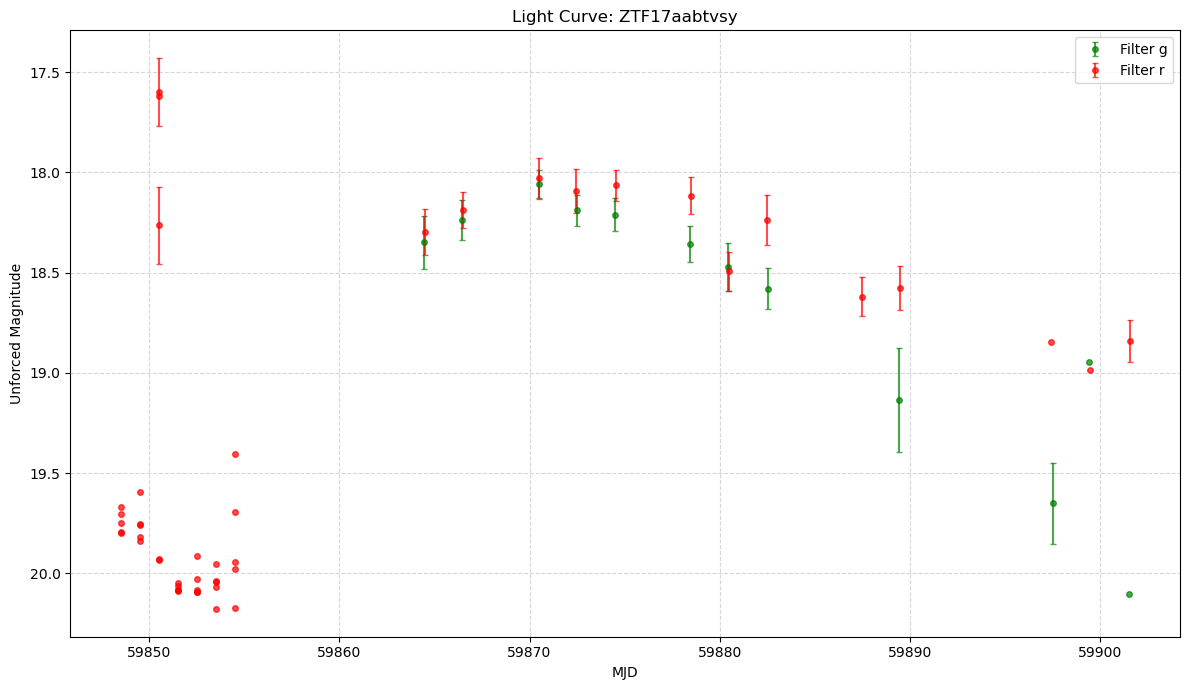

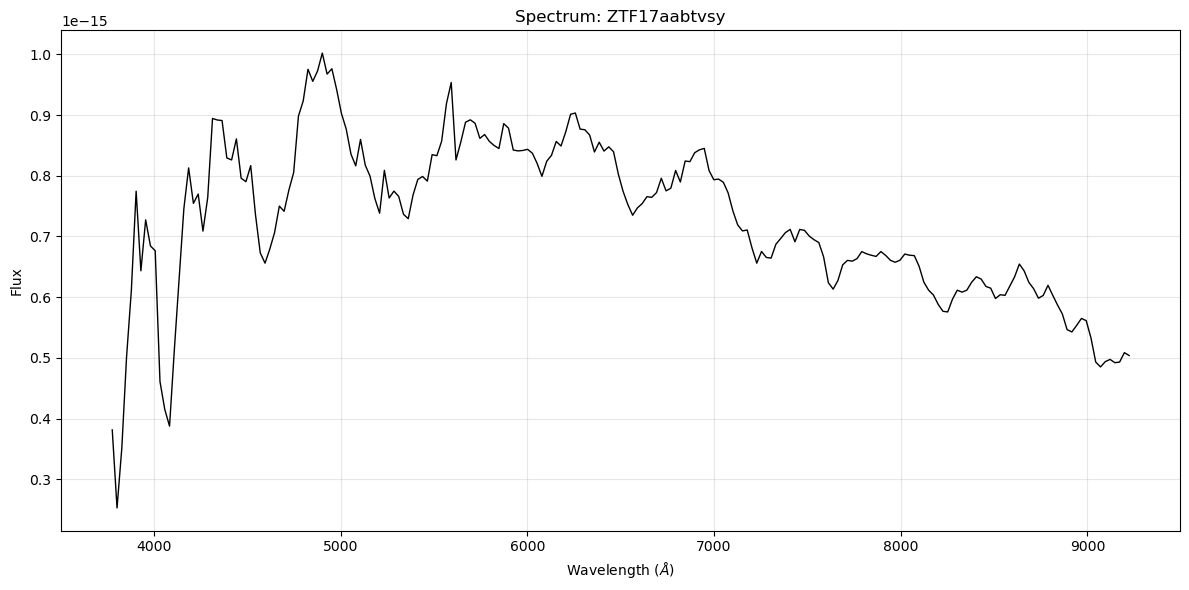

In [ ]:
# Plot light curves and spectra for downloaded objects
if 'download_results' in locals() and download_results:
    total = len(download_results)
    
    for idx, result in enumerate(download_results, 1):
        ztf_id = result['ztf_id']
        lasair_csv_path = result['lasair_csv_path']
        tns_ascii_path = result['tns_ascii_path']
        
        # Convert string paths to Path objects if they exist
        lasair_path = Path(lasair_csv_path) if lasair_csv_path else None
        tns_path = Path(tns_ascii_path) if tns_ascii_path else None
        
        # Skip if no data available
        if lasair_path is None and tns_path is None:
            print(f"[{idx}/{total}] {ztf_id}: Skipping (no data downloaded)")
            continue
        
        try:
            run_dir = project_root / "runs" / ztf_id
            plot_results = plot_object_data(
                ztf_id,
                lasair_path,
                tns_path,
                run_dir,
                project_root
            )
            
            # Print results
            if plot_results['light_curve_path']:
                print(f"[{idx}/{total}] {ztf_id}: Light curve → {plot_results['light_curve_path']}")
            if plot_results['spectrum_path']:
                print(f"[{idx}/{total}] {ztf_id}: Spectrum → {plot_results['spectrum_path']}")
        except Exception as e:
            print(f"[{idx}/{total}] {ztf_id}: Plotting failed - {str(e)}")

    print(f"\n Plotting complete for {total} object(s)")
else:
    print("\n No download results found. Run the download cell first.")

In [28]:
# Format selected objects_to_process for sncosmo and save as ztf_cosmo.csv

from utils import process_sncosmo

# Construct DataFrame from currently processed objects
if objects_to_process.empty:
    print("✗ No objects to process for sncosmo export.")
else:
    cosmo_df = pd.DataFrame(objects_to_process)

    # Rename columns to match sncosmo expectations
    col_map = {
        "ZTFID": "ztf_id",
        "IAUID": "iauid",
        "RA": "ra",
        "Dec": "dec",
        "type": "type",
        "redshift": "redshift",
        "peakt": "peak_time",
        "peakmag": "peak_mag",
        "peakabs": "peak_abs",
        "peakfilt": "filter",
        "A_V": "av",
    }

    rename_columns = {orig: new for orig, new in col_map.items() if orig in cosmo_df.columns}
    cosmo_df = cosmo_df.rename(columns=rename_columns)

    cosmo_path = project_root / "data" / "ztf_cosmo.csv"
    cosmo_df.to_csv(cosmo_path, index=False)
    print(f"Saved sncosmo-formatted catalog to {cosmo_path}")

    # Process with sncosmo and save FITS file
    run_dir = project_root / "runs" / ztf_id
    fits_path = process_sncosmo(cosmo_df, run_dir, source='hsiao')
    print(f"Sncosmo processing complete. FITS file saved to: {fits_path}")

Saved sncosmo-formatted catalog to /Users/david/Code/msc/project/data/ztf_cosmo.csv
Saved sncosmo models to /Users/david/Code/msc/project/runs/ZTF17aabtvsy/sncosmo/2026-01-25_sncosmo_models.fits
Sncosmo processing complete. FITS file saved to: /Users/david/Code/msc/project/runs/ZTF17aabtvsy/sncosmo/2026-01-25_sncosmo_models.fits
